In [1]:
cd ..

/pless_nfs/home/zeyu/github/gwuvision/reverse-pheno


In [2]:
import pandas as pd
import numpy as np
import torch
import pickle, pickle5
from torch import nn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from cycler import cycler

In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

In [5]:
import matplotlib
matplotlib.rcParams['text.usetex'] = False

In [6]:
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['savefig.dpi'] = 150

In [7]:
task_name = 'rgb_june_res50_by_plot_512'
time_stamp = '20220112_115923546' 
model_ep = 33
train_result = torch.load('./results/{}/{}/epoch_{}_train.pth'.format(task_name, time_stamp ,model_ep))

In [8]:
def path_to_timestamp(x):
    return [i.split('/')[-1].split('.')[0] for i in x]

In [9]:
vectors = r['gap_output']
label_df = pd.DataFrame(r['labels'])
# label_df[['row', 'column', 'plot_num']] = label_df['plot'].str.split('_', expand=True)
label_df['row'] = label_df['plot_row'].astype(int)
label_df['column'] = label_df['plot_column'].astype(int)
label_df['plot_num'] = label_df['plot'].astype(int)

In [ ]:
with open('./dataset_split.pkl', 'rb') as f:
    abby_image_split = pickle5.load(f)

In [12]:
train_timestamp = path_to_timestamp(train_result['image_paths'])

In [13]:
train_label_df = pd.DataFrame(train_result['labels'])
# label_df[['row', 'column', 'plot_num']] = label_df['plot'].str.split('_', expand=True)
train_label_df['timestamp'] = train_timestamp

In [ ]:
gene_labels_path = './cultivar_labels.csv'
gene_labels_df = pd.read_csv(gene_labels_path)
gene_labels_df = gene_labels_df[['Range', 'Column', 'leaf_wax', 'dw2', 'd_locus', 'ma', 'tan1']]
gene_labels_df = gene_labels_df.rename(columns={'leaf_wax': 'gene_leaf_wax', 'dw2': 'gene_dw2', 'd_locus': 'gene_d_locus',
                                                'ma':'gene_ma', 'tan1':'gene_tan1'})
gene_labels_df = gene_labels_df.dropna()
gene_labels_df['Range'] = gene_labels_df['Range'].astype(int)
gene_labels_df['Column'] = gene_labels_df['Column'].astype(int)

In [15]:
all_label_with_traits = train_label_df.reset_index()\
                            .merge(gene_labels_df, left_on=['plot_row', 'plot_column'], right_on=['Range', 'Column'], how='left')\
                            .set_index('index')
all_label_with_traits = all_label_with_traits.drop(['Range', 'Column'], axis=1)
all_label_with_traits = all_label_with_traits.rename(columns={'cultivar':'cultivars'})

In [16]:
all_label_with_traits

,cultivars,plot,scan_date,plot_row,plot_column,cultivar_int,plot_cls,timestamp,gene_leaf_wax,gene_dw2,gene_d_locus,gene_ma,gene_tan1
index,,,,,,,,,,,,,
0,PI_196049,717,736495,45,13,58,599,2017-06-15__14-09-22-095,2.0,2.0,2.0,2.0,0.0
1,PI_196049,717,736508,45,13,58,599,2017-06-28__11-48-13-995,2.0,2.0,2.0,2.0,0.0
2,PI_196049,717,736495,45,13,58,599,2017-06-15__14-09-23-306,2.0,2.0,2.0,2.0,0.0
3,PI_196049,717,736503,45,13,58,599,2017-06-23__12-59-50-013,2.0,2.0,2.0,2.0,0.0
4,PI_196049,717,736489,45,13,58,599,2017-06-09__12-10-28-020,2.0,2.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
166016,PI_152860,651,736483,41,11,18,541,2017-06-03__12-07-16-915,2.0,2.0,0.0,2.0,2.0
166017,PI_152860,651,736495,41,11,18,541,2017-06-15__13-52-36-686,2.0,2.0,0.0,2.0,2.0
166018,PI_152860,651,736501,41,11,18,541,2017-06-21__12-44-36-340,2.0,2.0,0.0,2.0,2.0


## Using faiss

In [17]:
from metric import compute_knn
from sklearn.metrics import r2_score, accuracy_score
from scipy.stats import mode
import faiss

In [18]:
class KNNRegressor:
    def __init__(self, n_neighbors, gpu=None):
        self.n_neighbors = n_neighbors
        self.gpu = gpu
        self.X = None
        self.y = None
        self.index = None
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.index = faiss.IndexFlatL2(X.shape[1])
        if self.gpu is not None:
            res = faiss.StandardGpuResources()
            self.index = faiss.index_cpu_to_gpu(res, self.gpu, self.index)
        self.index.add(X)
        
    def predict(self, x):
        nn_distance, nn_index = self.index.search(x, self.n_neighbors)
        #breakpoint()
        with np.errstate(divide='ignore'):
            weight = 1. / nn_distance#.numpy()
        inf_mask = np.isinf(weight)
        inf_row = np.any(inf_mask, axis=1)
        weight[inf_row] = inf_mask[inf_row]
        # pred = (weight * self.y[nn_index.numpy()]).sum(axis=1)/weight.sum(axis=1)
        pred = (weight * self.y[nn_index]).sum(axis=1)/weight.sum(axis=1)
        return pred
    
    def score(self, x, y):
        pred = self.predict(x)
        score = r2_score(y, pred)
        return score
    
    
class KNNClassifier:
    def __init__(self, n_neighbors, gpu=None):
        self.n_neighbors = n_neighbors
        self.gpu = gpu
        self.X = None
        self.y = None
        self.index = None
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.index = faiss.IndexFlatL2(X.shape[1])
        if self.gpu is not None:
            res = faiss.StandardGpuResources()
            self.index = faiss.index_cpu_to_gpu(res, self.gpu, self.index)
        self.index.add(X)
        
    def predict(self, x):
        nn_distance, nn_index = self.index.search(x, self.n_neighbors)
        votes = self.y[nn_index]
        predictions = np.array([mode(x)[0][0] for x in votes])
        return predictions
    
    def score(self, x, y):
        pred = self.predict(x)
        score = accuracy_score(y, pred)
        return score

# Per day predict of canopy height, leaf length, width, genetypes

## Per day predict of genetype

In [19]:
gene_type_list = ['gene_leaf_wax', 'gene_dw2', 'gene_d_locus', 'gene_ma', 'gene_tan1' ]
gene_show_color = {'gene_leaf_wax': 'c', 'gene_dw2': 'm', 'gene_d_locus': 'y', 'gene_ma': 'r', 'gene_tan1': 'b' }
gene_show_marker =  {'gene_leaf_wax': 'o', 'gene_dw2': 's', 'gene_d_locus': 'v', 'gene_ma': '^', 'gene_tan1': '*' }
gene_show_name =  {'gene_leaf_wax': 'leaf wax', 'gene_dw2': 'dw', 'gene_d_locus': 'd locus', 'gene_ma': 'ma', 'gene_tan1': 'tan' }

In [20]:
def balance_sample_idx(df, col, pos_val, neg_val, print_ratio=False):
        on_index = df[df[col]==pos_val].index.to_numpy()
        off_index = df[df[col]==neg_val].index.to_numpy()
        less_type = np.argmin([on_index.shape[0], off_index.shape[0]])
        if print_ratio:
            print(f"origin pos:neg = {len(on_index)}:{len(off_index)}")
        if less_type == 0:
            type_len = on_index.shape[0]
            off_index = rs.choice(off_index, size=type_len, replace=False)
        else:
            type_len = off_index.shape[0]
            on_index = rs.choice(on_index, size=type_len, replace=False)
        return np.concatenate([on_index, off_index])

In [21]:
def compute_per_day_gene_new_split(gene_type, data_split,feature_type='gap_output', balance_select=True):
    nnc = KNNClassifier(n_neighbors=5, gpu=0)
    # train_cultivars, test_cultivars
    all_label_with_traits = pd.concat([train_label_with_traits, val_label_with_traits]).reset_index()
    all_vectors = np.concatenate([train_result[feature_type], val_result[feature_type]])
    # using local var 
    new_train_label_with_traits = all_label_with_traits[all_label_with_traits['cultivars'].isin(data_split['train_cultivars'])]
    new_val_label_with_traits = all_label_with_traits[all_label_with_traits['cultivars'].isin(data_split['test_cultivars'])]
    train_vectors = all_vectors[new_train_label_with_traits.index]
    val_vectors = all_vectors[new_val_label_with_traits.index]
    new_train_label_with_traits = new_train_label_with_traits.reset_index()
    new_val_label_with_traits = new_val_label_with_traits.reset_index()
    
    gallery_dataset_df = new_train_label_with_traits[new_train_label_with_traits[gene_type]!=-1].dropna(subset=[gene_type])
    gallery_dataset_vectors = train_vectors[gallery_dataset_df.index]
    nnc.fit(gallery_dataset_vectors, gallery_dataset_df[gene_type].to_numpy())
    if balance_select:
        selected_idx = balance_sample_idx(new_val_label_with_traits, gene_type, 2, 0)
    else:
        selected_idx = new_val_label_with_traits.dropna(subset=[gene_type]).index
    overall_score = nnc.score(val_vectors[selected_idx], new_val_label_with_traits[gene_type][selected_idx].to_numpy())
    print(f"whole season {gene_type} score: {overall_score:.3f}")
    gene_day_score = []
    for day in range(0, new_val_label_with_traits['scan_date'].max() - new_val_label_with_traits['scan_date'].min()):
        day_df = new_val_label_with_traits[new_val_label_with_traits['scan_date'] == 736432+day].dropna(subset=[gene_type])
        if len(day_df) < 400:
            continue
        if balance_select:
            val_index = balance_sample_idx(day_df, gene_type, 2, 0)
        else:
            val_index = day_df.index
        if len(val_index) < 2:
            continue
        score = nnc.score(val_vectors[val_index], day_df[gene_type][val_index].to_numpy())
        gene_day_score.append([day, score])
    gene_day_score = np.array(gene_day_score)
    del nnc
    plt.plot(gene_day_score[:, 0], gene_day_score[:,1], label=gene_type.split('_')[-1])
    plt.ylim([0, 1])
    plt.xlabel('day')
    plt.ylabel('accuracy')
    title = f'5-nn accuracy of {gene_type} prediction per day, overall acc: {overall_score:.2f}'
    plt.title(title)

## Check two source (from inference and Abby) label consistency

In [22]:
# all_label_with_traits = pd.concat([train_label_with_traits, val_label_with_traits]).reset_index(drop=True)
for i in gene_type_list:
    print(f"===={i}====")
    gene_name = i[5:]
    train_ims_timestamp = path_to_timestamp(abby_image_split[gene_name]['train_ims'])
    print(f"\ttrain label diff sum:{(all_label_with_traits.set_index('timestamp').loc[train_ims_timestamp][i] - np.array(abby_image_split[gene_name]['train_labels'])*2).abs().sum()}")
    test_ims_timestamp = path_to_timestamp(abby_image_split[gene_name]['test_ims'])
    print(f"\ttest label diff sum:{(all_label_with_traits.set_index('timestamp').loc[test_ims_timestamp][i] - np.array(abby_image_split[gene_name]['test_labels'])*2).abs().sum()}")
    print(f"train ratio ref:alt = {(np.array(abby_image_split[gene_name]['train_labels']) == 0).sum()}:{(np.array(abby_image_split[gene_name]['train_labels']) == 1).sum()}")
    print(f"val ratio ref:alt = {(np.array(abby_image_split[gene_name]['test_labels']) == 0).sum()}:{(np.array(abby_image_split[gene_name]['test_labels']) == 1).sum()}")
    print(f"val ratio ref:alt = {(all_label_with_traits.set_index('timestamp').loc[test_ims_timestamp][i] == 0).sum()}:{(all_label_with_traits.set_index('timestamp').loc[test_ims_timestamp][i] == 2).sum()}")
    selected_df = all_label_with_traits.set_index('timestamp').loc[train_ims_timestamp]
    print(f"train cultivar  count ratio = {selected_df[selected_df[i] == 0].groupby(['cultivars']).size().shape[0]}:{selected_df[selected_df[i] == 2].groupby(['cultivars']).size().shape[0]}")
    print(f"train plot  count ratio = {selected_df[selected_df[i] == 0].groupby(['plot']).size().shape[0]}:{selected_df[selected_df[i] == 2].groupby(['plot']).size().shape[0]}")
    print(f"train cultivar day count ratio = {selected_df[selected_df[i] == 0].groupby(['cultivars', 'scan_date']).size().shape[0]}:{selected_df[selected_df[i] == 2].groupby(['cultivars', 'scan_date']).size().shape[0]}")
    print(f"train plot day count ratio = {selected_df[selected_df[i] == 0].groupby(['plot', 'scan_date']).size().shape[0]}:{selected_df[selected_df[i] == 2].groupby(['plot', 'scan_date']).size().shape[0]}")
    selected_df = all_label_with_traits.set_index('timestamp').loc[test_ims_timestamp]
    print(f"val cultivar  count ratio = {selected_df[selected_df[i] == 0].groupby(['cultivars']).size().shape[0]}:{selected_df[selected_df[i] == 2].groupby(['cultivars']).size().shape[0]}")
    print(f"val plot  count ratio = {selected_df[selected_df[i] == 0].groupby(['plot']).size().shape[0]}:{selected_df[selected_df[i] == 2].groupby(['plot']).size().shape[0]}")
    print(f"val cultivar day count ratio = {selected_df[selected_df[i] == 0].groupby(['cultivars', 'scan_date']).size().shape[0]}:{selected_df[selected_df[i] == 2].groupby(['cultivars', 'scan_date']).size().shape[0]}")
    print(f"val plot day count ratio = {selected_df[selected_df[i] == 0].groupby(['plot', 'scan_date']).size().shape[0]}:{selected_df[selected_df[i] == 2].groupby(['plot', 'scan_date']).size().shape[0]}")
    
    

====gene_leaf_wax====
	train label diff sum:0.0
	test label diff sum:0.0
train ratio ref:alt = 6700:11400
val ratio ref:alt = 3400:3400
val ratio ref:alt = 3400:3400
train cultivar  count ratio = 67:114
train plot  count ratio = 134:228
train cultivar day count ratio = 1427:2405
train plot day count ratio = 2441:4236
val cultivar  count ratio = 34:34
val plot  count ratio = 68:68
val cultivar day count ratio = 715:721
val plot day count ratio = 1218:1240
====gene_dw2====
	train label diff sum:0.0
	test label diff sum:0.0
train ratio ref:alt = 8000:10500
val ratio ref:alt = 4000:4000
val ratio ref:alt = 4000:4000
train cultivar  count ratio = 80:105
train plot  count ratio = 160:210
train cultivar day count ratio = 1683:2225
train plot day count ratio = 2908:3865
val cultivar  count ratio = 40:40
val plot  count ratio = 80:80
val cultivar day count ratio = 837:831
val plot day count ratio = 1447:1449
====gene_d_locus====
	train label diff sum:0.0
	test label diff sum:0.0
train ratio ref

In [23]:
all_dates = all_label_with_traits['timestamp'].str.split('__', expand=True)[0].unique()
all_dates.sort()
all_dates

array(['2017-06-01', '2017-06-02', '2017-06-03', '2017-06-04',
       '2017-06-05', '2017-06-06', '2017-06-09', '2017-06-11',
       '2017-06-12', '2017-06-13', '2017-06-14', '2017-06-15',
       '2017-06-16', '2017-06-17', '2017-06-18', '2017-06-19',
       '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23',
       '2017-06-26', '2017-06-27', '2017-06-28', '2017-06-29',
       '2017-06-30'], dtype=object)

In [24]:
def compute_per_day_gene_new_img_split(gene_type, data_split,feature_type='gap_output', classifier=KNNClassifier(n_neighbors=5, gpu=0), balance_select=False, return_model=False):
    nnc = classifier
    
    train_ims_timestamp = path_to_timestamp(data_split['train_ims'])
    test_ims_timestamp = path_to_timestamp(data_split['test_ims'])
    # train_cultivars, test_cultivars
    # all_label_with_traits = pd.concat([train_label_with_traits, val_label_with_traits]).reset_index(drop=True)
    # all_vectors = np.concatenate([train_result[feature_type], val_result[feature_type]])
    global all_label_with_traits
    all_vectors = train_result[feature_type].numpy()
    all_label_with_traits['index'] = all_label_with_traits.index
    train_index = all_label_with_traits.set_index('timestamp').loc[train_ims_timestamp]['index']
    val_index = all_label_with_traits.set_index('timestamp').loc[test_ims_timestamp]['index']
    # using local var 
    new_train_label_with_traits = all_label_with_traits.loc[train_index]
    new_val_label_with_traits = all_label_with_traits.loc[val_index]
    train_vectors = all_vectors[train_index]
    val_vectors = all_vectors[val_index]
    new_train_label_with_traits = new_train_label_with_traits.reset_index(drop=True)
    new_val_label_with_traits = new_val_label_with_traits.reset_index(drop=True)
    
    gallery_dataset_df = new_train_label_with_traits[new_train_label_with_traits[gene_type]!=-1].dropna(subset=[gene_type])
    gallery_dataset_vectors = train_vectors[gallery_dataset_df.index]
    nnc.fit(gallery_dataset_vectors, gallery_dataset_df[gene_type].to_numpy())
    if balance_select:
        selected_idx = balance_sample_idx(new_val_label_with_traits, gene_type, 2, 0)
        print(f"balance slected {selected_idx.shape[0]} from {new_val_label_with_traits.shape[0]}")
    else:
        selected_idx = new_val_label_with_traits.dropna(subset=[gene_type]).index
        print(f"Non-nan selected {selected_idx.shape[0]} from {new_val_label_with_traits.shape[0]}")
    overall_score = nnc.score(val_vectors[selected_idx], new_val_label_with_traits[gene_type][selected_idx].to_numpy())
    overall_pred = nnc.predict(val_vectors[selected_idx])
    overall_result_df = new_val_label_with_traits.loc[selected_idx,[gene_type, 'cultivars']]
    overall_result_df['pred'] = overall_pred
    cultivar_result_df = overall_result_df.groupby('cultivars').agg(lambda x: pd.Series.mode(x)[0])
    cultivar_mode_acc = (cultivar_result_df['pred'] == cultivar_result_df[gene_type]).mean()
    print(f"whole season {gene_type} score: {overall_score:.3f}")
    print(f'mode by cultivar acc: {cultivar_mode_acc:.3f}')
    gene_day_score = []
    for day in range(0, all_label_with_traits['scan_date'].max() - all_label_with_traits['scan_date'].min()):
        #if day in [6,7,9,10,17, 23,24]:
        #    gene_day_score.append([day, np.nan])
        #    continue
        day_df = new_val_label_with_traits[new_val_label_with_traits['scan_date'] == 736432+49+day].dropna(subset=[gene_type])
        if len(day_df) < 0:
            gene_day_score.append([day, np.nan])
            continue
        if balance_select:
            val_index = balance_sample_idx(day_df, gene_type, 2, 0)
        else:
            val_index = day_df.index
        if len(val_index) < 2:
            gene_day_score.append([day, np.nan])
            continue
        score = nnc.score(val_vectors[val_index], day_df[gene_type][val_index].to_numpy())
        gene_day_score.append([day, score])
    gene_day_score = np.array(gene_day_score)
    if not return_model:
        del nnc
    plt.plot(gene_day_score[:, 0], gene_day_score[:,1], #label=gene_type.split('_')[-1], 
             label=gene_show_name[gene_type], 
             marker=gene_show_marker[gene_type],
             color=gene_show_color[gene_type])
    plt.ylim([0.4, 1])
    plt.xlabel('day')
    plt.ylabel('accuracy')
    title = f'5-nn accuracy of {gene_type} prediction per day, overall acc: {overall_score:.2f}'
    plt.title(title)
    return_list = []
    if return_model:
        return_list.append(nnc)
    else:
        return None

Non-nan selected 6800 from 6800
whole season gene_leaf_wax score: 0.641
mode by cultivar acc: 0.632
Non-nan selected 8000 from 8000
whole season gene_dw2 score: 0.660
mode by cultivar acc: 0.750
Non-nan selected 4200 from 4200
whole season gene_d_locus score: 0.669
mode by cultivar acc: 0.667
Non-nan selected 2000 from 2000
whole season gene_ma score: 0.556
mode by cultivar acc: 0.500
Non-nan selected 5400 from 5400
whole season gene_tan1 score: 0.682
mode by cultivar acc: 0.741


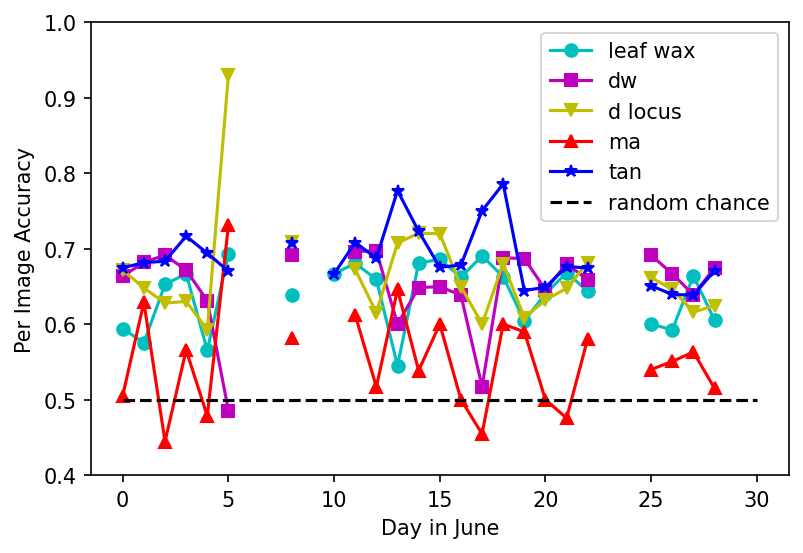

In [25]:
rs = np.random.RandomState(42)
for gene_type in gene_type_list:
    ds_split = abby_image_split[gene_type[5:]]
    compute_per_day_gene_new_img_split(gene_type, ds_split, classifier=KNNClassifier(n_neighbors=11, gpu=0), balance_select=False)
plt.plot([0, 30], [0.5, 0.5], 'k--', label='random chance')
# plt.title('10-nn genetic prediction accuracy per day')
plt.title('')
plt.xlabel('Day in June')
plt.ylabel('Per Image Accuracy')
plt.legend(loc='upper right')

Non-nan selected 6800 from 6800
whole season gene_leaf_wax score: 0.658
mode by cultivar acc: 0.647
Non-nan selected 8000 from 8000
whole season gene_dw2 score: 0.674
mode by cultivar acc: 0.713
Non-nan selected 4200 from 4200
whole season gene_d_locus score: 0.665
mode by cultivar acc: 0.667
Non-nan selected 2000 from 2000
whole season gene_ma score: 0.569
mode by cultivar acc: 0.500
Non-nan selected 5400 from 5400
whole season gene_tan1 score: 0.682
mode by cultivar acc: 0.704


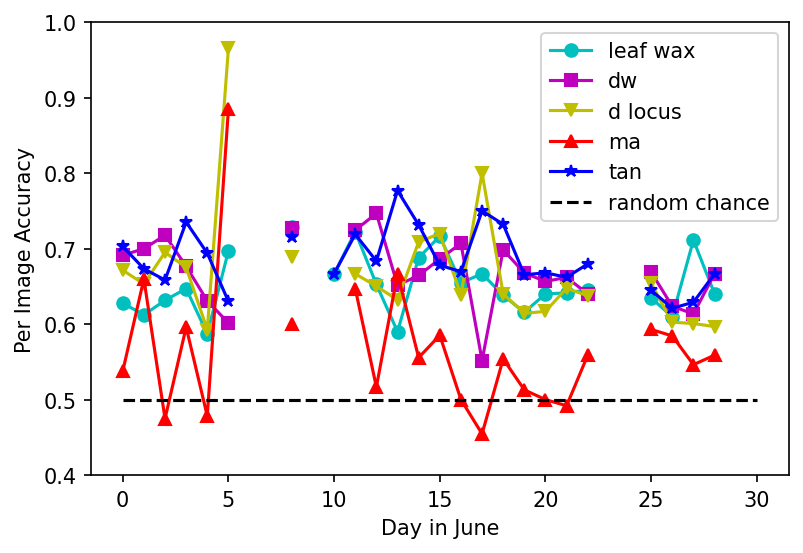

In [26]:
rs = np.random.RandomState(42)
for gene_type in gene_type_list:
    ds_split = abby_image_split[gene_type[5:]]
    reg = make_pipeline(PCA(n_components=30), svm.SVC(kernel='rbf'))
    compute_per_day_gene_new_img_split(gene_type, ds_split, classifier=reg, balance_select=False)
plt.plot([0, 30], [0.5, 0.5], 'k--', label='random chance')
# plt.title('PCA-SVM genetic prediction accuracy per day')
plt.title('')
plt.xlabel('Day in June')
plt.ylabel('Per Image Accuracy')
plt.legend(loc='upper right')

In [27]:
pool_method = 'max'

In [28]:
all_vector_df = pd.DataFrame(train_result['gap_output'].numpy())
all_vector_df = pd.concat([all_label_with_traits.reset_index(drop=True), all_vector_df], axis=1)

In [29]:
# all_vector_df['origin_index'] = all_vector_df.index
all_vector_df = all_vector_df.set_index('timestamp')

In [30]:
vector_start_pos= 10 + 3

In [31]:
all_vector_df.iloc[:,vector_start_pos]

timestamp
2017-06-15__14-09-22-095    0.986770
2017-06-28__11-48-13-995    1.046890
2017-06-15__14-09-23-306    0.331056
2017-06-23__12-59-50-013    0.659218
2017-06-09__12-10-28-020    1.656514
                              ...   
2017-06-03__12-07-16-915    0.266123
2017-06-15__13-52-36-686    1.193826
2017-06-21__12-44-36-340    0.451356
2017-06-21__12-44-39-359    0.582070
2017-06-23__18-48-00-113    0.723959
Name: 0, Length: 166021, dtype: float32

#### Per Plot

In [32]:
def compute_per_plot_day_ebd_per_day_gene_new_image_split(gene_type, classifier=KNNClassifier(n_neighbors=2, gpu=0), balance_train=True, balance_select=True, repeat=20, random_state=None):
    if random_state == None:
        rs = np.random.RandomState()
    else:
        rs = random_state
    nnc = classifier
    train_ims_timestamp = path_to_timestamp(abby_image_split[gene_type[5:]]['train_ims'])
    test_ims_timestamp = path_to_timestamp(abby_image_split[gene_type[5:]]['test_ims'])
    train_vector_df = all_vector_df.loc[train_ims_timestamp]
    val_vector_df = all_vector_df.loc[test_ims_timestamp]
    train_pooled_vector_df = train_vector_df.groupby(['cultivars','scan_date', 'plot', 'plot_row', 'plot_column']).max().reset_index()
    val_pooled_vector_df = val_vector_df.groupby(['cultivars','scan_date', 'plot', 'plot_row', 'plot_column']).max().reset_index()
    cultivar_gene_df = train_pooled_vector_df[['cultivars',gene_type]].drop_duplicates()
    ref_size = len(cultivar_gene_df[cultivar_gene_df[gene_type]==0])
    alt_size = len(cultivar_gene_df[cultivar_gene_df[gene_type]==2])
    print(ref_size, alt_size)
    if balance_train:
        if ref_size > alt_size:
            ref_cultivar_gene_idx = rs.choice(cultivar_gene_df[cultivar_gene_df[gene_type]==0].index, alt_size, replace=False)
            ref_cultivar_gene_df = cultivar_gene_df.loc[ref_cultivar_gene_idx]
            alt_cultivar_gene_df = cultivar_gene_df[cultivar_gene_df[gene_type]==2]
        else:
            alt_cultivar_gene_idx = rs.choice(cultivar_gene_df[cultivar_gene_df[gene_type]==2].index, ref_size, replace=False)
            alt_cultivar_gene_df = cultivar_gene_df.loc[alt_cultivar_gene_idx]
            ref_cultivar_gene_df = cultivar_gene_df[cultivar_gene_df[gene_type]==0]

        gallery_cultivars = np.concatenate([alt_cultivar_gene_df['cultivars'], ref_cultivar_gene_df['cultivars']], axis=0)
        gallery_df = train_pooled_vector_df[train_pooled_vector_df['cultivars'].isin(gallery_cultivars)]
        gallery_dataset_vectors = np.float32(gallery_df.iloc[:, vector_start_pos:].to_numpy())
        print(gallery_dataset_vectors.shape)
        gallery_dataset_values = gallery_df[gene_type].to_numpy()
    else:
        gallery_dataset_vectors = np.float32(train_pooled_vector_df.iloc[:, vector_start_pos:].to_numpy())
        gallery_dataset_values = train_pooled_vector_df[gene_type].to_numpy()
    
    nnc.fit(np.ascontiguousarray(gallery_dataset_vectors), gallery_dataset_values)
    overall_score_list = []
    for i in range(repeat):
        if balance_select:
            query_index = balance_sample_idx(val_pooled_vector_df, gene_type, 2, 0)
        else:
            query_index = val_pooled_vector_df[gene_type].dropna().index
        query_dataset_vectors = np.float32(val_pooled_vector_df.loc[query_index].iloc[:, vector_start_pos:].to_numpy())
        query_dataset_values = val_pooled_vector_df[gene_type][query_index].to_numpy()
        overall_score = nnc.score(np.ascontiguousarray(query_dataset_vectors), query_dataset_values)
        overall_score_list.append(overall_score)
    mean_overall_score = sum(overall_score_list) / len(overall_score_list)
    print(f"whole season {gene_type} score: {mean_overall_score:.3f}")
    gene_day_score = []
    totall_num_sample = 0
    totall_day = 0
    for day in range(1, 30):#range(val_pooled_vector_df['scan_date'].min(), val_pooled_vector_df['scan_date'].max()+1):
        day_df = val_pooled_vector_df[val_pooled_vector_df['scan_date'].astype(int) == 736432 + day+49].dropna(subset=[gene_type])
        # print(len(day_df))
        if day in [6,7,9,10,23,24]:
            gene_day_score.append([day, np.nan])
            continue
        if len(day_df) < 30:
            gene_day_score.append([day, np.nan])
            continue
        score_list = []
        for i in range(repeat):
            if balance_select:
                val_index = balance_sample_idx(day_df, gene_type, 2, 0)
            else:
                val_index = day_df.index
            totall_num_sample += len(val_index)
            totall_day += 1
            score = nnc.score(np.ascontiguousarray(np.float32(day_df.loc[val_index].iloc[:, vector_start_pos:].to_numpy())), day_df[gene_type][val_index].to_numpy())
            score_list.append(score)
        mean_score = sum(score_list)/len(score_list)
        gene_day_score.append([day, mean_score])
    avg_sample_per_day = totall_num_sample/totall_day
    print(f"\taverage sample per day {avg_sample_per_day:.2f}")
    gene_day_score = np.array(gene_day_score)
    del nnc
    plt.plot(gene_day_score[:, 0], gene_day_score[:,1], #label=gene_type.split('_')[-1], 
             label=gene_show_name[gene_type], 
             marker=gene_show_marker[gene_type],
             color=gene_show_color[gene_type])
    plt.ylim([0.4, 1])
    plt.xlabel('day')
    plt.ylabel('accuracy')
    title = f'5-nn accuracy of {gene_type} prediction per day, overall acc: {overall_score:.2f}'
    plt.title(title)

67 114
(4949, 2048)
whole season gene_leaf_wax score: 0.662
	average sample per day 106.95
80 105
(5847, 2048)
whole season gene_dw2 score: 0.682
	average sample per day 132.30
43 127
(3195, 2048)
whole season gene_d_locus score: 0.685
	average sample per day 71.26
21 167
(1514, 2048)
whole season gene_ma score: 0.701
	average sample per day 34.59
133 53
(3855, 2048)
whole season gene_tan1 score: 0.699
	average sample per day 89.70


Text(0.5, 1.0, '5-nn genetic prediction accuracy per day')

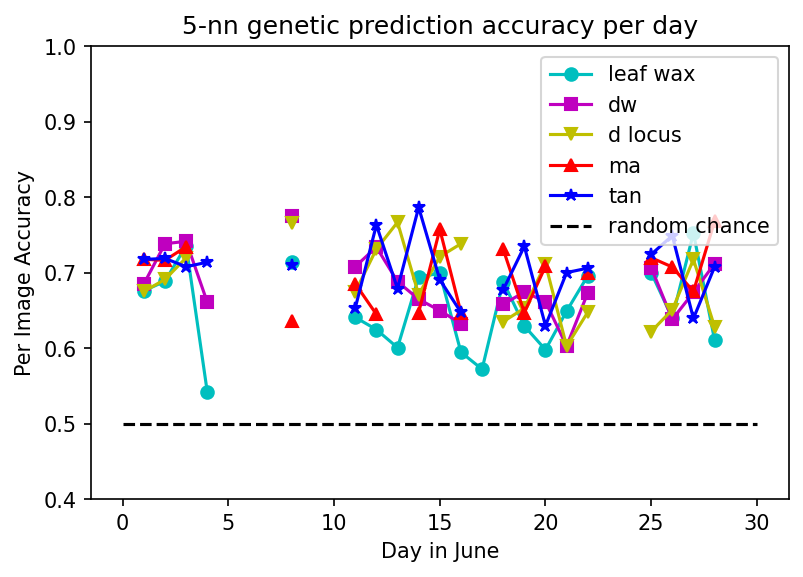

In [33]:
rs = np.random.RandomState(42)
for gene_type in gene_type_list:
    compute_per_plot_day_ebd_per_day_gene_new_image_split(gene_type,classifier=KNNClassifier(n_neighbors=5, gpu=0), random_state=rs)
plt.plot([0, 30], [0.5, 0.5], 'k--', label='random chance')
plt.xlabel('Day in June')
plt.ylabel('Per Image Accuracy')
plt.legend(loc='upper right')
plt.title('5-nn genetic prediction accuracy per day')

67 114
(4949, 2048)
whole season gene_leaf_wax score: 0.699
	average sample per day 106.95
80 105
(5847, 2048)
whole season gene_dw2 score: 0.685
	average sample per day 132.30
43 127
(3195, 2048)
whole season gene_d_locus score: 0.741
	average sample per day 71.26
21 167
(1514, 2048)
whole season gene_ma score: 0.761
	average sample per day 34.59
133 53
(3855, 2048)
whole season gene_tan1 score: 0.733
	average sample per day 89.70


Text(0.5, 1.0, 'PCA-SVM genetic prediction accuracy per day')

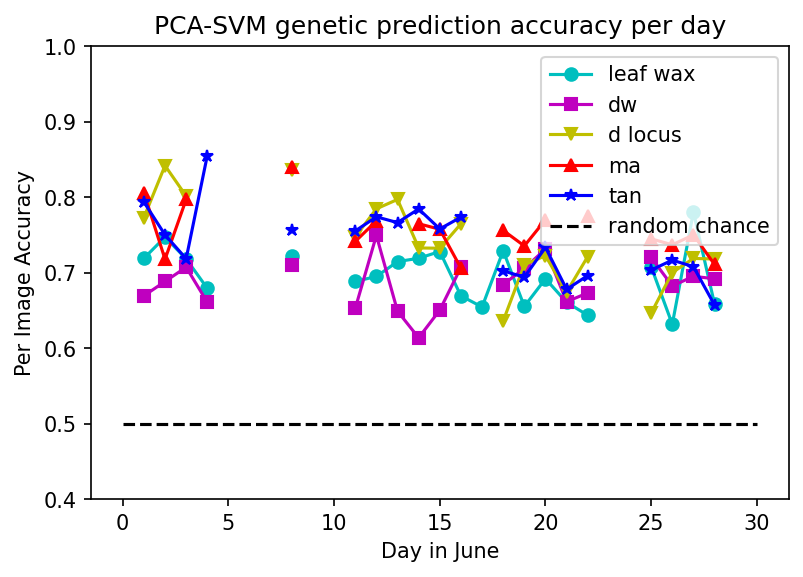

In [34]:
rs = np.random.RandomState(42)
for gene_type in gene_type_list:
    reg = make_pipeline(PCA(n_components=30), svm.SVC(kernel='rbf', random_state=rs))
    compute_per_plot_day_ebd_per_day_gene_new_image_split(gene_type,classifier=reg, random_state=rs)
plt.plot([0, 30], [0.5, 0.5], 'k--', label='random chance')
plt.xlabel('Day in June')
plt.ylabel('Per Image Accuracy')
plt.legend(loc='upper right')
plt.title('PCA-SVM genetic prediction accuracy per day')

#### per cultivar day

In [35]:
def compute_per_cultivar_day_ebd_per_day_gene_new_image_split(gene_type, classifier=KNNClassifier(n_neighbors=2, gpu=0), balance_train=True, balance_select=True, balance_select_train=False, repeat=20, random_state=None):
    nnc = classifier
    if random_state == None:
        rs = np.random.RandomState()
    else:
        rs = random_state
    train_ims_timestamp = path_to_timestamp(abby_image_split[gene_type[5:]]['train_ims'])
    test_ims_timestamp = path_to_timestamp(abby_image_split[gene_type[5:]]['test_ims'])
    train_vector_df = all_vector_df.loc[train_ims_timestamp]
    val_vector_df = all_vector_df.loc[test_ims_timestamp]
    train_pooled_vector_df = train_vector_df.groupby(['cultivars','scan_date']).max().reset_index()
    val_pooled_vector_df = val_vector_df.groupby(['cultivars','scan_date']).max().reset_index()
    cultivar_gene_df = train_pooled_vector_df[['cultivars',gene_type]].drop_duplicates()
    ref_size = len(cultivar_gene_df[cultivar_gene_df[gene_type]==0])
    alt_size = len(cultivar_gene_df[cultivar_gene_df[gene_type]==2])
    print(ref_size, alt_size)
    if balance_train:
        if ref_size > alt_size:
            ref_cultivar_gene_idx = np.random.choice(cultivar_gene_df[cultivar_gene_df[gene_type]==0].index, alt_size, replace=False)
            ref_cultivar_gene_df = cultivar_gene_df.loc[ref_cultivar_gene_idx]
            alt_cultivar_gene_df = cultivar_gene_df[cultivar_gene_df[gene_type]==2]
        else:
            alt_cultivar_gene_idx = np.random.choice(cultivar_gene_df[cultivar_gene_df[gene_type]==2].index, ref_size, replace=False)
            alt_cultivar_gene_df = cultivar_gene_df.loc[alt_cultivar_gene_idx]
            ref_cultivar_gene_df = cultivar_gene_df[cultivar_gene_df[gene_type]==0]

        gallery_cultivars = np.concatenate([alt_cultivar_gene_df['cultivars'], ref_cultivar_gene_df['cultivars']], axis=0)
        gallery_df = train_pooled_vector_df[train_pooled_vector_df['cultivars'].isin(gallery_cultivars)]
        gallery_dataset_vectors = np.float32(gallery_df.iloc[:, vector_start_pos:].to_numpy())
        print(gallery_dataset_vectors.shape)
        gallery_dataset_values = gallery_df[gene_type].to_numpy()
    else:
        gallery_dataset_vectors = np.float32(train_pooled_vector_df.iloc[:, vector_start_pos:].to_numpy())
        gallery_dataset_values = train_pooled_vector_df[gene_type].to_numpy()
    
    nnc.fit(np.ascontiguousarray(gallery_dataset_vectors), gallery_dataset_values)
    overall_score_list = []
    for i in range(repeat):
        if balance_select:
            query_index = balance_sample_idx(val_pooled_vector_df, gene_type, 2, 0)
        else:
            query_index = val_pooled_vector_df[gene_type].dropna().index
        query_dataset_vectors = np.float32(val_pooled_vector_df.loc[query_index].iloc[:, vector_start_pos:].to_numpy())
        query_dataset_values = val_pooled_vector_df[gene_type][query_index].to_numpy()
        overall_score = nnc.score(np.ascontiguousarray(query_dataset_vectors), query_dataset_values)
        overall_score_list.append(overall_score)
    mean_overall_score = sum(overall_score_list) / len(overall_score_list)
    print(f"whole season {gene_type} score: {mean_overall_score:.3f}")
    gene_day_score = []
    totall_num_sample = 0
    totall_day = 0
    for day in range(0, 30):#range(val_pooled_vector_df['scan_date'].min(), val_pooled_vector_df['scan_date'].max()+1):
        day_df = val_pooled_vector_df[val_pooled_vector_df['scan_date'].astype(int) == 736432 + day+49].dropna(subset=[gene_type])
        # print(len(day_df))
        if day in [6,7,9,10,23,24]:
            gene_day_score.append([day, np.nan])
            continue
        if len(day_df) < 15:
            gene_day_score.append([day, np.nan])
            continue
        score_list = []
        for i in range(repeat):
            if balance_select:
                val_index = balance_sample_idx(day_df, gene_type, 2, 0)
            else:
                val_index = day_df.index
            totall_num_sample += len(val_index)
            totall_day += 1
            score = nnc.score(np.ascontiguousarray(np.float32(day_df.loc[val_index].iloc[:, vector_start_pos:].to_numpy())), day_df[gene_type][val_index].to_numpy())
            score_list.append(score)
        mean_score = sum(score_list)/len(score_list)
        gene_day_score.append([day, mean_score])
    avg_sample_per_day = totall_num_sample/totall_day
    print(f"\taverage sample per day {avg_sample_per_day:.2f}")
    gene_day_score = np.array(gene_day_score)
    del nnc
    plt.plot(gene_day_score[:, 0], gene_day_score[:,1], #label=gene_type.split('_')[-1], 
             label=gene_show_name[gene_type], 
             marker=gene_show_marker[gene_type],
             color=gene_show_color[gene_type])
    plt.ylim([0.4, 1])
    plt.xlabel('day')
    plt.ylabel('accuracy')
    title = f'5-nn accuracy of {gene_type} prediction per day, overall acc: {overall_score:.2f}'
    plt.title(title)

67 114
(2844, 2048)
whole season gene_leaf_wax score: 0.682
	average sample per day 61.22
80 105
(3378, 2048)
whole season gene_dw2 score: 0.721
	average sample per day 71.48
43 127
(1806, 2048)
whole season gene_d_locus score: 0.752
	average sample per day 38.27
21 167
(876, 2048)
whole season gene_ma score: 0.694
	average sample per day 19.24
133 53
(2246, 2048)
whole season gene_tan1 score: 0.735
	average sample per day 48.52


Text(0.5, 1.0, '11-nn genetic prediction accuracy per day')

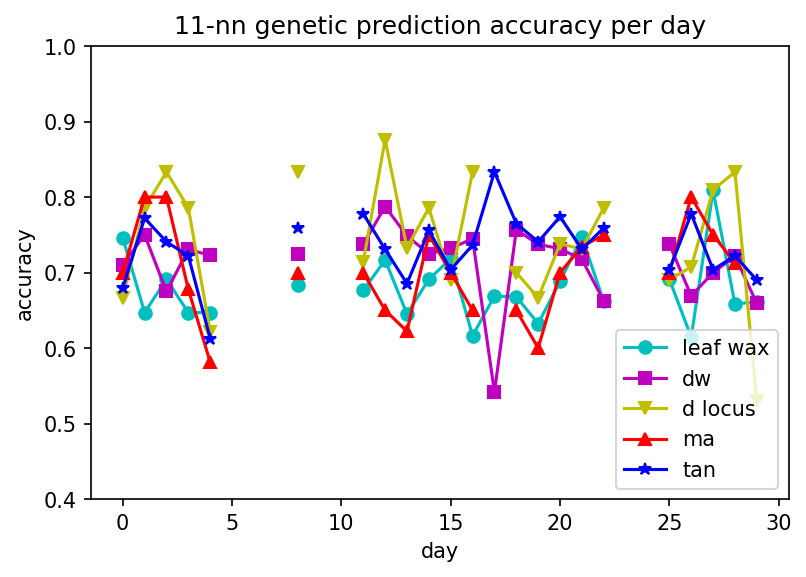

In [37]:
rs = np.random.RandomState(42)
for gene_type in gene_type_list:
    ds_split = abby_image_split[gene_type[5:]]
    compute_per_cultivar_day_ebd_per_day_gene_new_image_split(gene_type,classifier=KNNClassifier(n_neighbors=11, gpu=0), random_state=rs)
plt.legend()
plt.title('11-nn genetic prediction accuracy per day')

67 114
(2846, 2048)
whole season gene_leaf_wax score: 0.715
	average sample per day 61.22
80 105
(3379, 2048)
whole season gene_dw2 score: 0.700
	average sample per day 71.48
43 127
(1807, 2048)
whole season gene_d_locus score: 0.762
	average sample per day 38.27
21 167
(877, 2048)
whole season gene_ma score: 0.770
	average sample per day 19.24
133 53
(2244, 2048)
whole season gene_tan1 score: 0.768
	average sample per day 48.52


Text(0.5, 1.0, 'PCA-SVM genetic prediction accuracy per day')

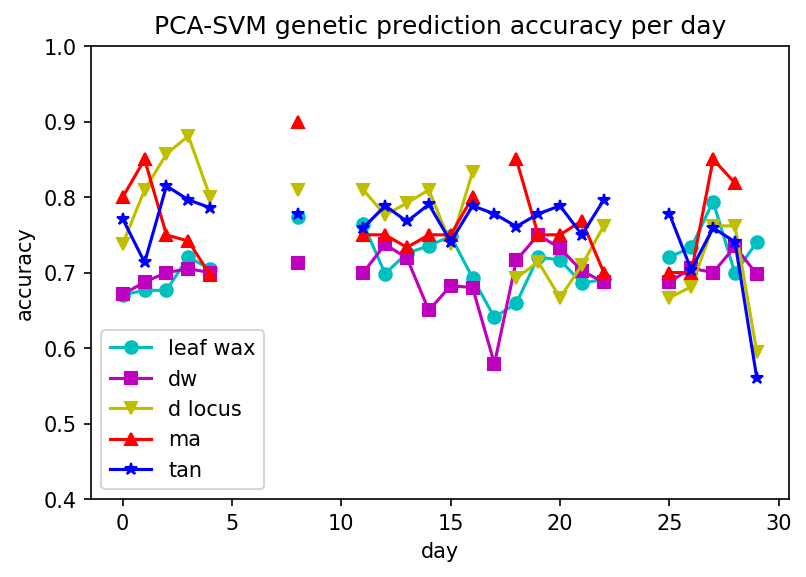

In [38]:
rs = np.random.RandomState(42)
for gene_type in gene_type_list:
    reg = make_pipeline(PCA(n_components=30), svm.SVC(kernel='rbf'))
    compute_per_cultivar_day_ebd_per_day_gene_new_image_split(gene_type,classifier=reg, random_state=rs)
plt.legend()
plt.title('PCA-SVM genetic prediction accuracy per day')